# Project task - Solar Energy Production
This notebook will contain the exploratory data analysis, all manipulation and cleaning of the given datasets and finally the creation of predictions using the different ML models

In [1]:
#importing necessary datasets
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

#Setting max display options to avoid local crashes
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
print("hello")

hello


## Reading in the datasets

In [2]:
Y_train_a = pd.read_parquet('data/A/train_targets.parquet')
Y_train_b = pd.read_parquet('data/B/train_targets.parquet')
Y_train_c = pd.read_parquet('data/C/train_targets.parquet')

In [3]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

In [4]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

In [5]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

### Combining the datasets
A seperate combined dataset will be made for the A, B and C location.\
Each location will have a X dataset (containing only feature values) and a complete training dataset (X_train combined with the Y_train values) which can be used to check for feature correlation. 


*Note: The resolution is different between the X and Y datasets, as Y each row in Y contains an hour and each row in X is per 15 minutes. To begin with the X datset will be naivly changed to have a resolution of every hour aswell. However we will later explore feature exploration techniques to retain more data from X by artifically increasing the resolution of the Y data*

#### Location A

In [6]:
#Create the X dataset for location A
X_train_estimated_a["estimated"] = 1.0
X_test_estimated_a["estimated"] = 1.0
X_train_observed_a["estimated"] = 0.0
X_train_observed_a["date_calc"] = X_train_observed_a["date_forecast"].copy() #date calc column added to observed data so that observed and estimated has equal nr cols

X_train_estimated_a["train/test"] = "train"
X_train_observed_a["train/test"] = "train"
X_test_estimated_a["train/test"] = "test"

X_all_a= pd.concat([X_train_observed_a, X_train_estimated_a, X_test_estimated_a], ignore_index=True)
X_all_a.set_index('date_forecast', inplace=True)

*Create the complete training set for A*

In [7]:
#Create the complete train dataset for location A
train_all_a = pd.concat([X_train_observed_a.drop("train/test", axis=1), X_train_estimated_a.drop("train/test", axis=1)], ignore_index=True)
train_all_a.set_index('date_forecast', inplace=True)

#remove all non hourly values
train_all_a = train_all_a[train_all_a.index.minute == 0]

#Set the index as the date forecast for y aswell
Y_train_a.set_index('time', inplace=True)

#Concatenate with y data
train_all_a = pd.concat([train_all_a, Y_train_a], axis=1)

In [8]:
train_all_a.head()

absolute_humidity_2m:gm3  air_density_2m:kgm3  \
2019-06-02 22:00:00                       7.7                1.230   
2019-06-02 23:00:00                       7.7                1.225   
2019-06-03 00:00:00                       7.7                1.221   
2019-06-03 01:00:00                       8.2                1.218   
2019-06-03 02:00:00                       8.8                1.219   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
2019-06-02 22:00:00           1744.900024               0.000000   
2019-06-02 23:00:00           1703.599976               0.000000   
2019-06-03 00:00:00           1668.099976               0.000000   
2019-06-03 01:00:00           1388.400024               0.000000   
2019-06-03 02:00:00           1108.500000            6546.899902   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
2019-06-02 22:00:00              0.0       1744.900024              0.0   
2019-06-02 23:00:00              0.0       1703.599976              0.0   
2019-06-03 00:00:00              0.0       1668.099976              0.0   
2019-06-03 01:00:00              0.0       1388.400024              0.0   
2019-06-03 02:00:00              9.8       1108.500000              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
2019-06-02 22:00:00      280.299988            0.0          0.000000   
2019-06-02 23:00:00      280.299988            0.0          0.000000   
2019-06-03 00:00:00      280.200012            0.0          0.000000   
2019-06-03 01:00:00      281.299988            0.0          0.000000   
2019-06-03 02:00:00      282.299988            4.3       7743.299805   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
2019-06-02 22:00:00           0.0              0.0                98.699997   
2019-06-02 23:00:00           0.0              0.0                99.599998   
2019-06-03 00:00:00           0.0              0.0               100.000000   
2019-06-03 01:00:00           0.0              0.0               100.000000   
2019-06-03 02:00:00           0.0              0.0               100.000000   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
2019-06-02 22:00:00          6.0                0.0               0.0   
2019-06-02 23:00:00          6.0                0.0               0.0   
2019-06-03 00:00:00          6.0                0.0               0.0   
2019-06-03 01:00:00          6.0                0.0               0.0   
2019-06-03 02:00:00          6.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
2019-06-02 22:00:00                0.0               0.0               0.0   
2019-06-02 23:00:00                0.0               0.0               0.0   
2019-06-03 00:00:00                0.0               0.0               0.0   
2019-06-03 01:00:00                0.0               0.0               0.0   
2019-06-03 02:00:00                0.0               0.0               0.0   

                     is_day:idx  is_in_shadow:idx  msl_pressure:hPa  \
2019-06-02 22:00:00         0.0               1.0       1006.799988   
2019-06-02 23:00:00         0.0               1.0       1005.500000   
2019-06-03 00:00:00         0.0               1.0       1004.599976   
2019-06-03 01:00:00         0.0               1.0       1004.400024   
2019-06-03 02:00:00         1.0               0.0       1003.400024   

                     precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
2019-06-02 22:00:00             0.0                   0.0         994.200012   
2019-06-02 23:00:00             0.0                   0.0         993.000000   
2019-06-03 00:00:00             0.0                   0.0         992.099976   
2019-06-03 01:00:00             0.0                   0.0         991.799988   
2019-06-03 02:00:00             0.0                   0.0         990.900024   

                

#### Location B

In [9]:
#Combine all data from B
X_train_estimated_b["estimated"] = 1.0
X_test_estimated_b["estimated"] = 1.0
X_train_observed_b["estimated"] = 0.0
X_train_observed_b["date_calc"] = X_train_observed_b["date_forecast"].copy()

X_train_estimated_b["train/test"] = "train"
X_train_observed_b["train/test"] = "train"
X_test_estimated_b["train/test"] = "test"

X_all_b= pd.concat([X_train_observed_b, X_train_estimated_b, X_test_estimated_b], ignore_index=True)

*Create the complete training set*

In [10]:
#Create the complete train dataset for location A
train_all_b = pd.concat([X_train_observed_b.drop("train/test", axis=1), X_train_estimated_b.drop("train/test", axis=1)], ignore_index=True)
train_all_b.set_index('date_forecast', inplace=True)
#remove all non hourly values
train_all_b = train_all_b[train_all_b.index.minute == 0]

#Set the index as the date forecast for y aswell
Y_train_b.set_index('time', inplace=True)

#Concatenate with y data
train_all_b = pd.concat([train_all_b, Y_train_b], axis=1)

In [11]:
train_all_b.head()

absolute_humidity_2m:gm3  air_density_2m:kgm3  \
2018-12-31 23:00:00                       NaN                  NaN   
2019-01-01 00:00:00                       5.6                1.239   
2019-01-01 01:00:00                       5.4                1.241   
2019-01-01 02:00:00                       5.5                1.238   
2019-01-01 03:00:00                       5.3                1.240   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
2018-12-31 23:00:00                   NaN                    NaN   
2019-01-01 00:00:00           1226.400024                    0.0   
2019-01-01 01:00:00           1157.599976                    0.0   
2019-01-01 02:00:00           1087.599976                    0.0   
2019-01-01 03:00:00           1016.400024                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
2018-12-31 23:00:00              NaN               NaN              NaN   
2019-01-01 00:00:00              0.0       1226.400024              0.0   
2019-01-01 01:00:00              0.0       1157.599976              0.0   
2019-01-01 02:00:00              0.0       1087.599976              0.0   
2019-01-01 03:00:00              0.0       1016.400024              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
2018-12-31 23:00:00             NaN            NaN               NaN   
2019-01-01 00:00:00      275.399994            0.0               0.0   
2019-01-01 01:00:00      274.700012            0.0               0.0   
2019-01-01 02:00:00      275.000000            0.0               0.0   
2019-01-01 03:00:00      274.500000            0.0               0.0   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
2018-12-31 23:00:00           NaN              NaN                      NaN   
2019-01-01 00:00:00           0.0              0.0                69.599998   
2019-01-01 01:00:00           0.0              0.0                98.099998   
2019-01-01 02:00:00           0.0              0.0                96.300003   
2019-01-01 03:00:00           0.0              0.0                97.199997   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
2018-12-31 23:00:00          NaN                NaN               NaN   
2019-01-01 00:00:00          7.0                0.0               0.0   
2019-01-01 01:00:00          7.0                0.0               0.0   
2019-01-01 02:00:00          7.0                0.0               0.0   
2019-01-01 03:00:00          7.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
2018-12-31 23:00:00                NaN               NaN               NaN   
2019-01-01 00:00:00                0.0               0.0               0.0   
2019-01-01 01:00:00                0.0               0.0               0.0   
2019-01-01 02:00:00                0.0               0.0               0.0   
2019-01-01 03:00:00                0.0               0.0               0.0   

                     is_day:idx  is_in_shadow:idx  msl_pressure:hPa  \
2018-12-31 23:00:00         NaN               NaN               NaN   
2019-01-01 00:00:00         0.0               1.0        987.400024   
2019-01-01 01:00:00         0.0               1.0        986.299988   
2019-01-01 02:00:00         0.0               1.0        985.900024   
2019-01-01 03:00:00         0.0               1.0        986.099976   

                     precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
2018-12-31 23:00:00             NaN                   NaN                NaN   
2019-01-01 00:00:00            0.00                   0.0         974.500000   
2019-01-01 01:00:00            0.05                   1.0         973.400024   
2019-01-01 02:00:00            0.00                   0.0         973.000000   
2019-01-01 03:00:00            0.00                   0.0         973.200012   

                

In [12]:
#Drop the first row, as it is not in the X data
train_all_b.drop("2018-12-31 23:00:00", inplace=True)

#### Location C

In [13]:
#Combine all data from C
X_train_estimated_c["estimated"] = 1.0
X_test_estimated_c["estimated"] = 1.0
X_train_observed_c["estimated"] = 0.0
X_train_observed_c["date_calc"] = X_train_observed_c["date_forecast"].copy()
X_train_estimated_c["train/test"] = "train"
X_train_observed_c["train/test"] = "train"
X_test_estimated_c["train/test"] = "test"

X_all_c= pd.concat([X_train_observed_c, X_train_estimated_c, X_test_estimated_c], ignore_index=True)

*Create Complete training data for location C*

In [14]:
#Create the complete train dataset for location A
train_all_c = pd.concat([X_train_observed_c.drop("train/test", axis=1), X_train_estimated_c.drop("train/test", axis=1)], ignore_index=True)
train_all_c.set_index('date_forecast', inplace=True)
#remove all non hourly values
train_all_c = train_all_c[train_all_c.index.minute == 0]

#Set the index as the date forecast for y aswell
Y_train_c.set_index('time', inplace=True)

#Concatenate with y data
train_all_c = pd.concat([train_all_c, Y_train_c], axis=1)

In [15]:
train_all_c.drop("2018-12-31 23:00:00", inplace=True)

#### Lets make a combined dataset for all locations
This is in order to quickly check correlations and get a brief overview about all locations

In [16]:
copy_a = X_all_a.copy()
copy_b = X_all_b.copy()
copy_c = X_all_c.copy()

copy_a["location"] = "A"
copy_b["location"] = "B"
copy_c["location"] = "C"
X_all = pd.concat([copy_a, copy_b, copy_c])

In [17]:
copy_a_train = train_all_a.copy()
copy_b_train = train_all_b.copy()
copy_c_train = train_all_c.copy()

copy_a_train["location"] = "A"
copy_b_train["location"] = "B"
copy_c_train["location"] = "C"

train_all = pd.concat([copy_a_train, copy_b_train, copy_c_train])

In [18]:
train_all.head()

absolute_humidity_2m:gm3  air_density_2m:kgm3  \
2019-06-02 22:00:00                       7.7                1.230   
2019-06-02 23:00:00                       7.7                1.225   
2019-06-03 00:00:00                       7.7                1.221   
2019-06-03 01:00:00                       8.2                1.218   
2019-06-03 02:00:00                       8.8                1.219   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
2019-06-02 22:00:00           1744.900024               0.000000   
2019-06-02 23:00:00           1703.599976               0.000000   
2019-06-03 00:00:00           1668.099976               0.000000   
2019-06-03 01:00:00           1388.400024               0.000000   
2019-06-03 02:00:00           1108.500000            6546.899902   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
2019-06-02 22:00:00              0.0       1744.900024              0.0   
2019-06-02 23:00:00              0.0       1703.599976              0.0   
2019-06-03 00:00:00              0.0       1668.099976              0.0   
2019-06-03 01:00:00              0.0       1388.400024              0.0   
2019-06-03 02:00:00              9.8       1108.500000              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  \
2019-06-02 22:00:00      280.299988            0.0          0.000000   
2019-06-02 23:00:00      280.299988            0.0          0.000000   
2019-06-03 00:00:00      280.200012            0.0          0.000000   
2019-06-03 01:00:00      281.299988            0.0          0.000000   
2019-06-03 02:00:00      282.299988            4.3       7743.299805   

                     direct_rad:W  direct_rad_1h:J  effective_cloud_cover:p  \
2019-06-02 22:00:00           0.0              0.0                98.699997   
2019-06-02 23:00:00           0.0              0.0                99.599998   
2019-06-03 00:00:00           0.0              0.0               100.000000   
2019-06-03 01:00:00           0.0              0.0               100.000000   
2019-06-03 02:00:00           0.0              0.0               100.000000   

                     elevation:m  fresh_snow_12h:cm  fresh_snow_1h:cm  \
2019-06-02 22:00:00          6.0                0.0               0.0   
2019-06-02 23:00:00          6.0                0.0               0.0   
2019-06-03 00:00:00          6.0                0.0               0.0   
2019-06-03 01:00:00          6.0                0.0               0.0   
2019-06-03 02:00:00          6.0                0.0               0.0   

                     fresh_snow_24h:cm  fresh_snow_3h:cm  fresh_snow_6h:cm  \
2019-06-02 22:00:00                0.0               0.0               0.0   
2019-06-02 23:00:00                0.0               0.0               0.0   
2019-06-03 00:00:00                0.0               0.0               0.0   
2019-06-03 01:00:00                0.0               0.0               0.0   
2019-06-03 02:00:00                0.0               0.0               0.0   

                     is_day:idx  is_in_shadow:idx  msl_pressure:hPa  \
2019-06-02 22:00:00         0.0               1.0       1006.799988   
2019-06-02 23:00:00         0.0               1.0       1005.500000   
2019-06-03 00:00:00         0.0               1.0       1004.599976   
2019-06-03 01:00:00         0.0               1.0       1004.400024   
2019-06-03 02:00:00         1.0               0.0       1003.400024   

                     precip_5min:mm  precip_type_5min:idx  pressure_100m:hPa  \
2019-06-02 22:00:00             0.0                   0.0         994.200012   
2019-06-02 23:00:00             0.0                   0.0         993.000000   
2019-06-03 00:00:00             0.0                   0.0         992.099976   
2019-06-03 01:00:00             0.0                   0.0         991.799988   
2019-06-03 02:00:00             0.0                   0.0         990.900024   

                

## Exploratory Data Analysis

Lets start by making some quick graphs of the all the data combined

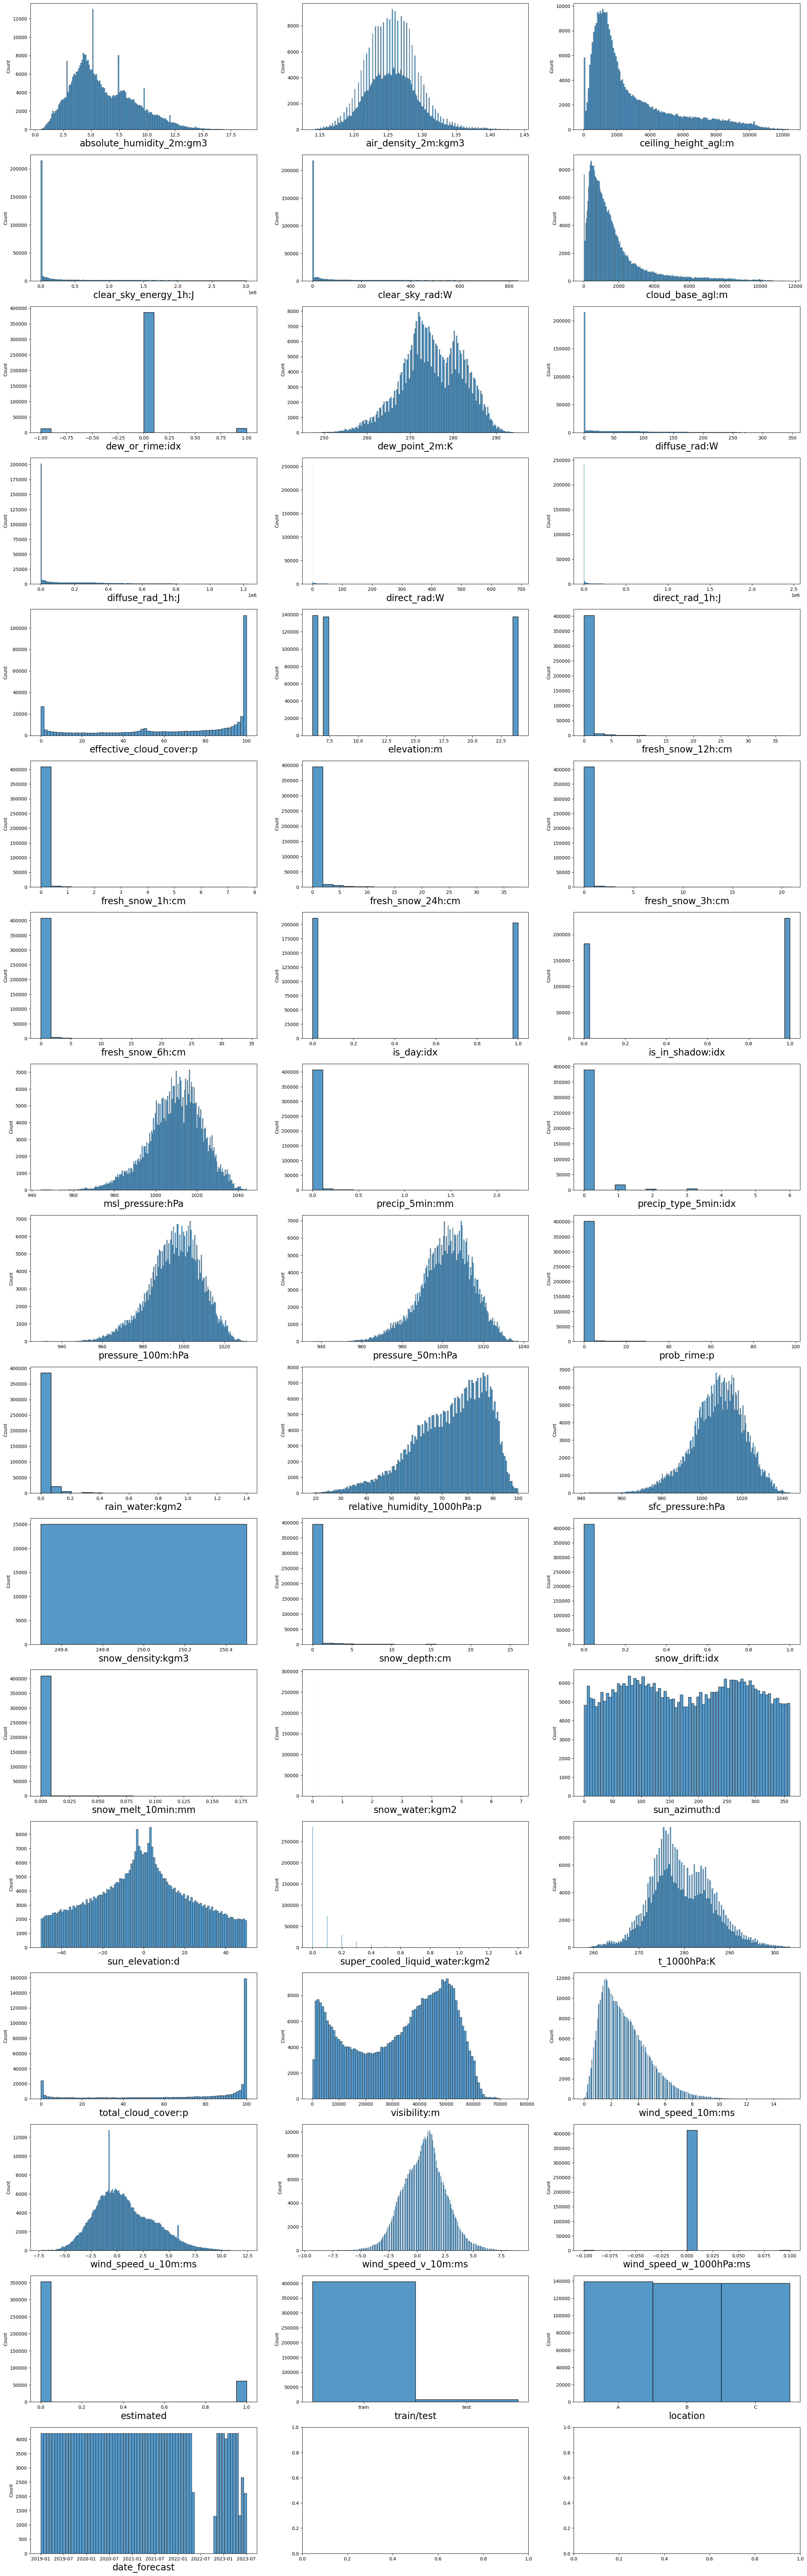

In [19]:
fig, axes = plt.subplots(nrows=17, ncols=3, figsize=(30, 100))
axes = axes.flatten()

for i, column in enumerate(X_all.drop("date_calc", axis=1).columns):
    sns.histplot(data=X_all[column], kde=False, ax=axes[i])
    axes[i].set_xlabel(column, fontsize = 20)


*Observations*
- Based on this is seems like snow density is completely filled with Nan values
- We have a random dip in the date forecast at the end of 2022
- Snow Density has VERY low count compared to the other features
- All the radian features have a strange distribution

#### Lets start to look at the correlation between the data and the target y values (PV measurement)

In [20]:
plt.figure(figsize = (50, 60), dpi=200)
sns.heatmap(train_all.drop(["location"], axis=1).corr(), annot = True); 

In [21]:
plt.figure(figsize = (50,90), dpi=200)
sns.heatmap(train_all.drop(["location"], axis=1).corr()[["pv_measurement"]], annot = True); 

In [23]:
train_all.drop(["location"], axis=1).corr()[["pv_measurement"]]

pv_measurement
absolute_humidity_2m:gm3              0.212681
air_density_2m:kgm3                  -0.275082
ceiling_height_agl:m                  0.125216
clear_sky_energy_1h:J                 0.581296
clear_sky_rad:W                       0.596610
cloud_base_agl:m                      0.112066
dew_or_rime:idx                      -0.009610
dew_point_2m:K                        0.214575
diffuse_rad:W                         0.521091
diffuse_rad_1h:J                      0.510671
direct_rad:W                          0.615520
direct_rad_1h:J                       0.598611
effective_cloud_cover:p              -0.138989
elevation:m                          -0.186294
fresh_snow_12h:cm                    -0.047894
fresh_snow_1h:cm                     -0.031325
fresh_snow_24h:cm                    -0.059904
fresh_snow_3h:cm                     -0.037278
fresh_snow_6h:cm                     -0.042248
is_day:idx                            0.382365
is_in_shadow:idx                     -0.418880
msl_pressure:hPa                      0.129704
precip_5min:mm                       -0.038228
precip_type_5min:idx                 -0.052279
pressure_100m:hPa                     0.146773
pressure_50m:hPa                      0.143074
prob_rime:p                          -0.051257
rain_water:kgm2                      -0.041471
relative_humidity_1000hPa:p          -0.243932
sfc_pressure:hPa                      0.139361
snow_density:kgm3                          NaN
snow_depth:cm                        -0.053285
snow_drift:idx                       -0.001738
snow_melt_10min:mm                   -0.018329
snow_water:kgm2                      -0.086162
sun_azimuth:d                        -0.041439
sun_elevation:d                       0.495572
super_cooled_liquid_water:kgm2       -0.075641
t_1000hPa:K                           0.273879
total_cloud_cover:p                  -0.118089
visibility:m                          0.139640
wind_speed_10m:ms                    -0.059389
wind_speed_u_10m:ms                  -0.040945
wind_speed_v_10m:ms                  -0.200126
wind_speed_w_1000hPa:ms               0.002152
estimated                            -0.058426
date_calc                             0.011064
pv_measurement                        1.000000

*Notes*
- wind_speed_w_1000hPa:ms seems to not be very important
- All snow values seem to not be very important (except maybe snow depth)
- dew_or_rime:idx is very useless

## Data Cleanup

In [24]:
data_a = train_all_a.dropna(axis=0).drop(['date_calc', 'estimated'], axis=1)
data_b = train_all_b.dropna(axis=0).drop(['date_calc', 'estimated'], axis=1)
data_c = train_all_c.dropna(axis=0).drop(['date_calc', 'estimated'], axis=1)

## Decision Tree Test

In [24]:
# from sklearn.tree import DecisionTreeRegressor 

# X_t = data_a.drop('pv_measurement',axis=1)
# y_t = data_a.pv_measurement
# model = DecisionTreeRegressor(random_state=1)
# model.fit(X_t, y_t)
# X_p = X_test_estimated_a.drop(['date_forecast', 'date_calc', 'estimated', 'train/test'], axis = 1)
# predictions = model.predict(X_p)
# out_pd = pd.concat([X_test_estimated_a.date_forecast, pd.DataFrame(predictions)], axis=1)
# out_pd=out_pd.rename(columns = {0:'prediction','date_forecast':'time'})
# out_pd['location'] = 'A'
# out_pd.set_index('time',inplace=True)

## AutoSKLearn

In [25]:
import autosklearn.classification

X_t = data_a.drop('pv_measurement',axis=1)
y_t = data_a.pv_measurement
model = autosklearn.classification.AutoSklearnClassifier(random_state=1)
model.fit(X_t, y_t)
X_p = X_test_estimated_a.drop(['date_forecast', 'date_calc', 'estimated', 'train/test'], axis = 1)
predictions = model.predict(X_p)
out_pd = pd.concat([X_test_estimated_a.date_forecast, pd.DataFrame(predictions)], axis=1)
out_pd=out_pd.rename(columns = {0:'prediction','date_forecast':'time'})
out_pd['location'] = 'A'
out_pd.set_index('time',inplace=True)

ModuleNotFoundError: No module named 'autosklearn'

## Create submission

In [ ]:
test = pd.read_csv('data/test.csv')
test.time = pd.to_datetime(test.time)
sample_submission = pd.read_csv('data/sample_submission.csv')
# test['prediction'] = np.random.rand(len(test))
test.set_index('time',inplace=True)
df1 = test
df2 = out_pd

merged_df = df1.reset_index().merge(df2.reset_index(), on=['time', 'location'], how='left', suffixes=('_original', '_new'))

# # Use combine_first to replace NaN values in 'prediction_new' with the original 'prediction' values
merged_df['prediction_new'] = merged_df['prediction_new'].combine_first(merged_df['prediction_original'])

# # Drop the original 'prediction' column
merged_df.drop('prediction_original', axis=1, inplace=True)

# # Rename 'prediction_new' to 'prediction'
merged_df.rename(columns={'prediction_new': 'prediction'}, inplace=True)

sample_submission = sample_submission[['id']].merge(merged_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('submission.csv', index=False)

## Submit

In [ ]:
# kaggle competitions submit -c solar-energy-production-forecasting -f submission.csv -m "Message"